# Import the dataset

In [196]:
from pyspark.sql import SparkSession
spark=SparkSession.builder.appName('churn_prediction').getOrCreate()

In [197]:
df=spark.read.csv('D:/HK6/Projects/Bank_Customer_Churn/churn.csv', header=True, inferSchema=True)
df.show()
df.printSchema()

+-----------+------------+-------+------+---+------+---------+---------------+-----------+-------------+----------------+-----+
|customer_id|credit_score|country|gender|age|tenure|  balance|products_number|credit_card|active_member|estimated_salary|churn|
+-----------+------------+-------+------+---+------+---------+---------------+-----------+-------------+----------------+-----+
|   15634602|         619| France|Female| 42|     2|      0.0|              1|          1|            1|       101348.88|    1|
|   15647311|         608|  Spain|Female| 41|     1| 83807.86|              1|          0|            1|       112542.58|    0|
|   15619304|         502| France|Female| 42|     8| 159660.8|              3|          1|            0|       113931.57|    1|
|   15701354|         699| France|Female| 39|     1|      0.0|              2|          0|            0|        93826.63|    0|
|   15737888|         850|  Spain|Female| 43|     2|125510.82|              1|          1|            1|

# Data Preparation

In [198]:
((df.count(), len(df.columns)))

(10000, 12)

In [199]:
#Count Null, NaN, None values in each columns
from pyspark.sql.functions import col,isnan, when, count
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+-----------+------------+-------+------+---+------+-------+---------------+-----------+-------------+----------------+-----+
|customer_id|credit_score|country|gender|age|tenure|balance|products_number|credit_card|active_member|estimated_salary|churn|
+-----------+------------+-------+------+---+------+-------+---------------+-----------+-------------+----------------+-----+
|          0|           0|      0|     0|  0|     0|      0|              0|          0|            0|               0|    0|
+-----------+------------+-------+------+---+------+-------+---------------+-----------+-------------+----------------+-----+



In [200]:
# Check for duplicate rows
duplicate_rows = df.groupBy(df.columns).count().filter(col("count") > 1)

# Print the result
if duplicate_rows.count() > 0:
    print("Dataset has duplicate rows")
else:
    print("Dataset has no duplicate rows")

Dataset has no duplicate rows


In [201]:
df=df.drop('customer_id')

In [202]:
df.summary().toPandas().transpose()

,0,1,2,3,4,5,6,7
summary,count,mean,stddev,min,25%,50%,75%,max
credit_score,10000,650.5288,96.65329873613035,350,584,652,717,850
country,10000,None,None,France,None,None,None,Spain
gender,10000,None,None,Female,None,None,None,Male
age,10000,38.9218,10.487806451704587,18,32,37,44,92
tenure,10000,5.0128,2.8921743770496837,0,3,5,7,10
balance,10000,76485.88928799961,62397.40520238599,0.0,0.0,97157.96,127638.35,250898.09
products_number,10000,1.5302,0.5816543579989917,1,1,1,2,4
credit_card,10000,0.7055,0.45584046447513327,0,0,1,1,1
active_member,10000,0.5151,0.49979692845891815,0,0,1,1,1


In [203]:
#Replace 0: No, 1: Yes
rep_cols = ['credit_card', 'active_member', 'churn']

for i in rep_cols:
    df = df.withColumn(i, when(col(i) == 1, 'Yes').otherwise('No'))

In [204]:
cat_cols=['country', 'gender', 'products_number', 'credit_card', 'active_member','churn']
num_cols=['credit_score', 'age', 'tenure', 'balance', 'estimated_salary']

In [205]:
#Convert datatype of categorical columns to category
from pyspark.sql.types import StringType
for i in cat_cols:
    df = df.withColumn(i, col(i).cast(StringType()))

In [206]:
df[num_cols].summary().toPandas().transpose()

,0,1,2,3,4,5,6,7
summary,count,mean,stddev,min,25%,50%,75%,max
credit_score,10000,650.5288,96.65329873613035,350,584,652,717,850
age,10000,38.9218,10.487806451704587,18,32,37,44,92
tenure,10000,5.0128,2.8921743770496837,0,3,5,7,10
balance,10000,76485.88928799961,62397.40520238599,0.0,0.0,97157.96,127638.35,250898.09
estimated_salary,10000,100090.2398809998,57510.49281769821,11.58,50972.6,100183.05,149381.32,199992.48


In [207]:
for i in cat_cols:
    print(i)
    df.groupBy(i).count().show()

country
+-------+-----+
|country|count|
+-------+-----+
|Germany| 2509|
| France| 5014|
|  Spain| 2477|
+-------+-----+

gender
+------+-----+
|gender|count|
+------+-----+
|Female| 4543|
|  Male| 5457|
+------+-----+

products_number
+---------------+-----+
|products_number|count|
+---------------+-----+
|              3|  266|
|              1| 5084|
|              4|   60|
|              2| 4590|
+---------------+-----+

credit_card
+-----------+-----+
|credit_card|count|
+-----------+-----+
|         No| 2945|
|        Yes| 7055|
+-----------+-----+

active_member
+-------------+-----+
|active_member|count|
+-------------+-----+
|           No| 4849|
|          Yes| 5151|
+-------------+-----+

churn
+-----+-----+
|churn|count|
+-----+-----+
|   No| 7963|
|  Yes| 2037|
+-----+-----+



# EDA

In [208]:
import matplotlib.pyplot as plt
import seaborn as sns

In [209]:
df.show()

+------------+-------+------+---+------+---------+---------------+-----------+-------------+----------------+-----+
|credit_score|country|gender|age|tenure|  balance|products_number|credit_card|active_member|estimated_salary|churn|
+------------+-------+------+---+------+---------+---------------+-----------+-------------+----------------+-----+
|         619| France|Female| 42|     2|      0.0|              1|        Yes|          Yes|       101348.88|  Yes|
|         608|  Spain|Female| 41|     1| 83807.86|              1|         No|          Yes|       112542.58|   No|
|         502| France|Female| 42|     8| 159660.8|              3|        Yes|           No|       113931.57|  Yes|
|         699| France|Female| 39|     1|      0.0|              2|         No|           No|        93826.63|   No|
|         850|  Spain|Female| 43|     2|125510.82|              1|        Yes|          Yes|         79084.1|   No|
|         645|  Spain|  Male| 44|     8|113755.78|              2|      

In [210]:
df_Pandas=df.toPandas()

## Univariate Analysis

### Target: Churn

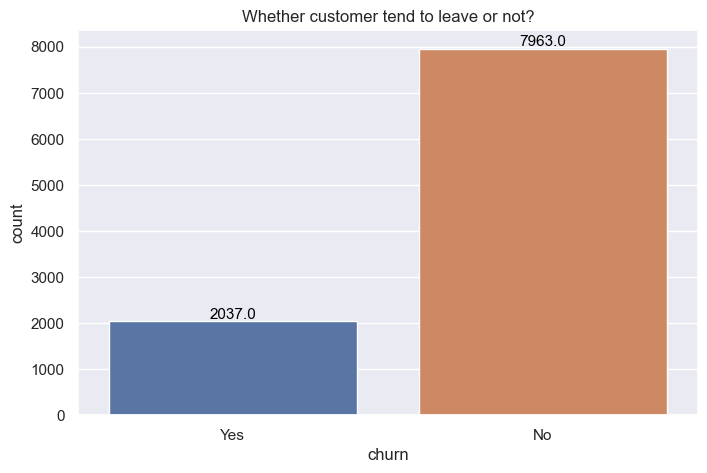

In [211]:
# Set the Seaborn theme and figure size
sns.set_theme()
plt.figure(figsize=(8, 5))

# Create the count plot
ax = sns.countplot(x='churn', data=df_Pandas)

# Set the plot title
plt.title('Whether customer tend to leave or not?')

# Add count labels above each bar
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                textcoords='offset points')

# Display the plot
plt.show()

Text(0.5, 1.0, 'Whether customer tend to leave or not?')

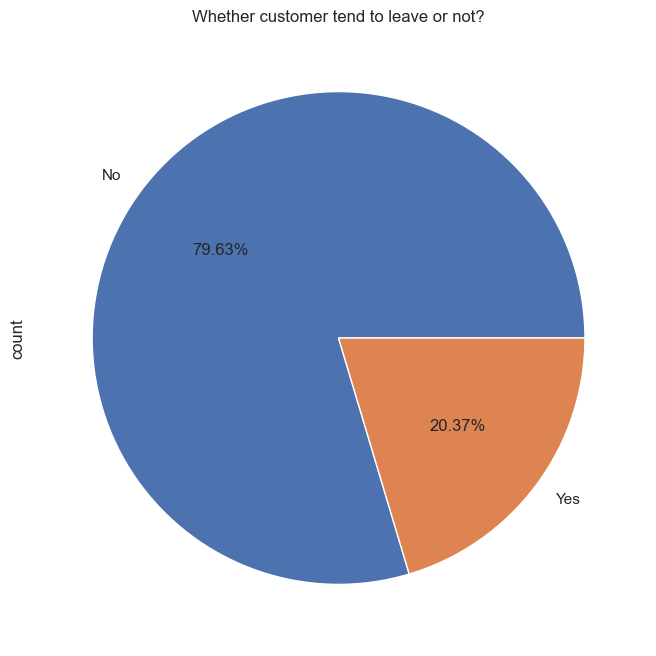

In [212]:
#Draw pie chart for churn
sns.set_theme()
plt.figure(figsize=(10,8))
ax = df_Pandas['churn'].value_counts().plot.pie(autopct='%1.2f%%')
#set title
plt.title('Whether customer tend to leave or not?')

### Demographic Features

In [213]:
cus_info_cat=['gender', 'country']
cus_info_num=['age', 'estimated_salary']

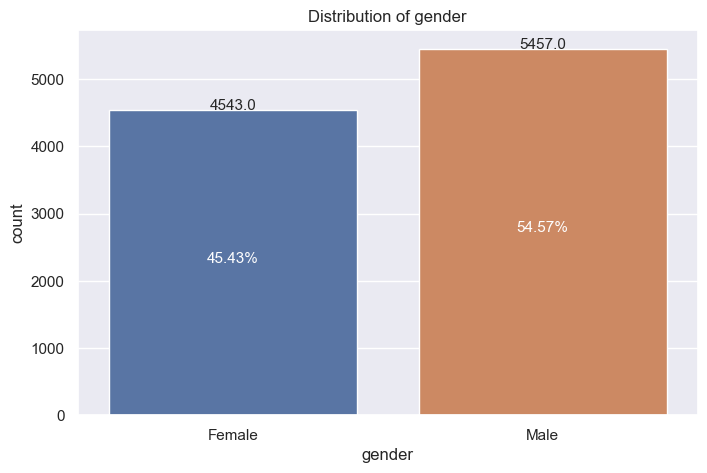

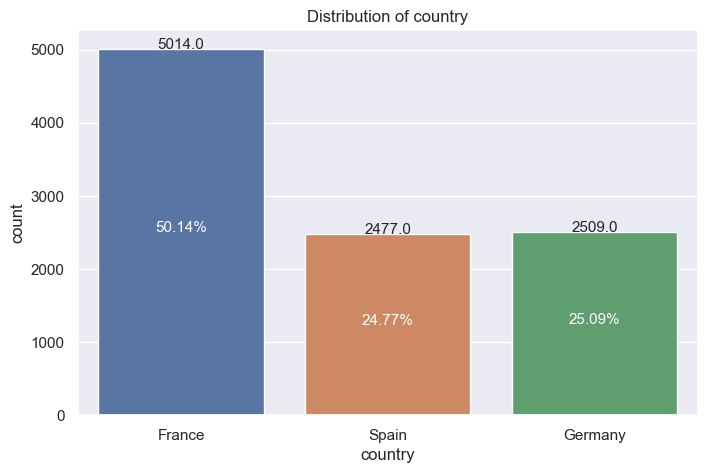

In [214]:
for i in cus_info_cat:
    plt.figure(figsize=(8,5))
    ax = sns.countplot(x=i, data=df_Pandas)
    plt.title(f'Distribution of {i}')
    # Add count and percentage above each bar
    total = float(len(df_Pandas))
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2., height+3, '{}'.format(height),
                ha="center", fontsize=11) 
        ax.text(p.get_x()+p.get_width()/2., height/2, '{:.2f}%'.format((height/total)*100),
                ha="center", fontsize=11, color='white')
    plt.show()

C:\Users\DELL\AppData\Local\Temp\ipykernel_16836\2830865488.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_Pandas[i], ax=ax[0])
C:\Users\DELL\AppData\Local\Temp\ipykernel_16836\2830865488.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_Pandas[i], ax=ax[0])


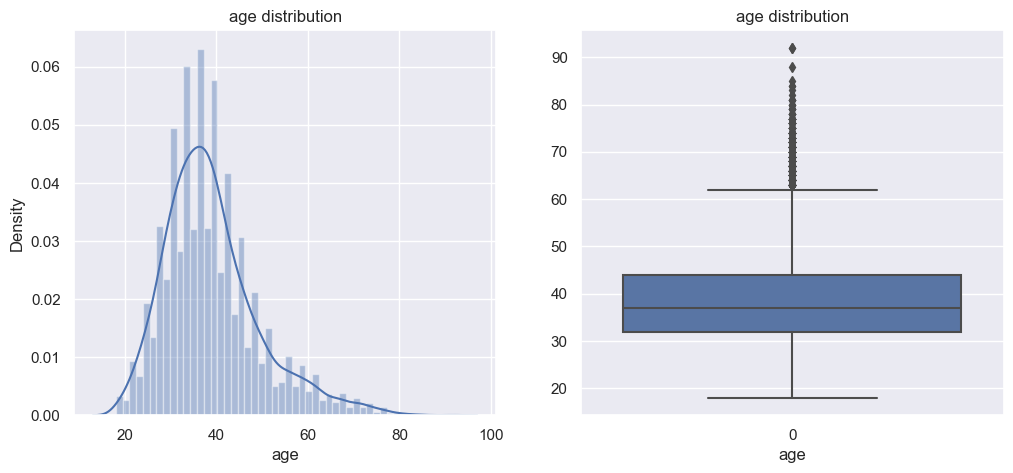

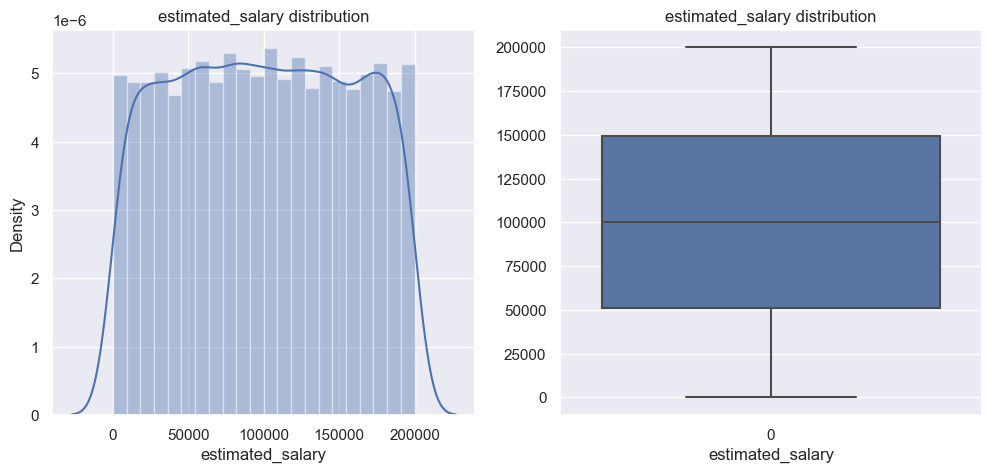

In [215]:
for i in cus_info_num:
  sns.set_theme()
  fig, ax = plt.subplots(1, 2, figsize=(12, 5))
  sns.distplot(df_Pandas[i], ax=ax[0])
  sns.boxplot(df_Pandas[i], ax=ax[1])
  #set xlabel and ylabel for boxplot
  ax[1].set_xlabel(i)
  ax[1].set_ylabel('')
  ax[1].set_title(f'{i} distribution')
  ax[0].set_title(f'{i} distribution')

### Information about the account

In [216]:
acc_info_num=['credit_score', 'tenure', 'balance']
acc_info_cat=['products_number', 'credit_card', 'active_member']

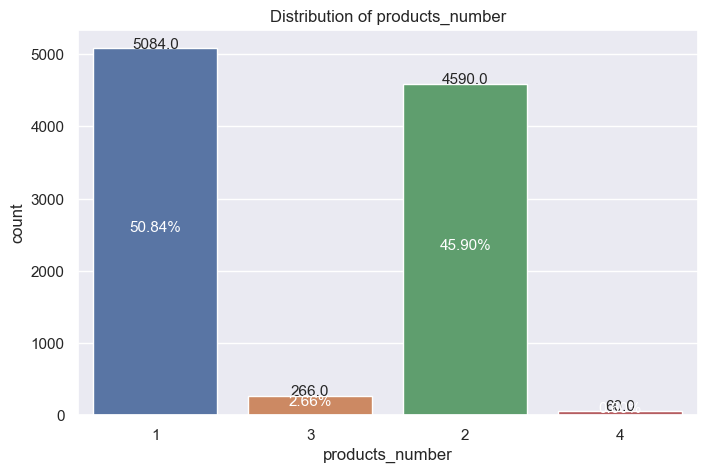

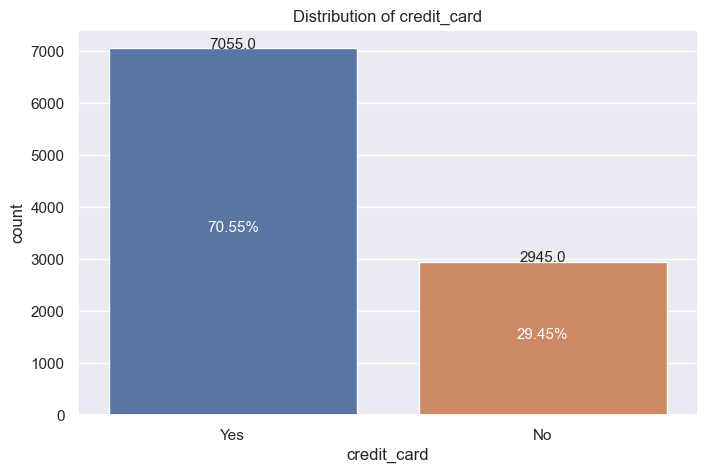

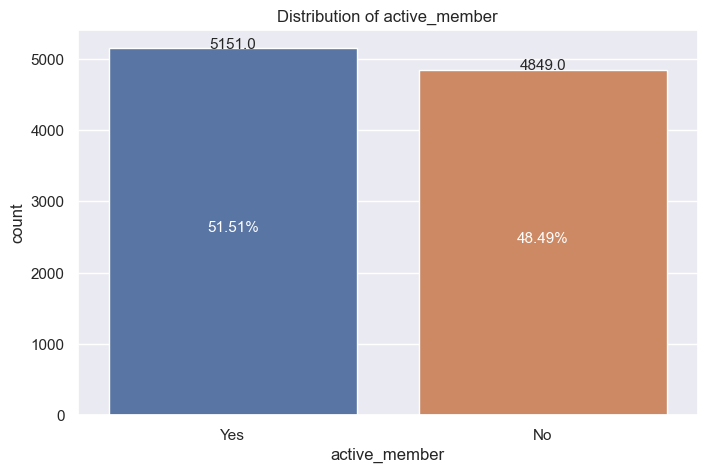

In [217]:
#Catetogical columns
for i in acc_info_cat:
    plt.figure(figsize=(8,5))
    ax = sns.countplot(x=i, data=df_Pandas)
    plt.title(f'Distribution of {i}')
    # Add count and percentage above each bar
    total = float(len(df_Pandas))
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2., height+3, '{}'.format(height),
                ha="center", fontsize=11) 
        ax.text(p.get_x()+p.get_width()/2., height/2, '{:.2f}%'.format((height/total)*100),
                ha="center", fontsize=11, color='white')
    plt.show()


C:\Users\DELL\AppData\Local\Temp\ipykernel_16836\1105200499.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_Pandas[i], ax=ax[0])
C:\Users\DELL\AppData\Local\Temp\ipykernel_16836\1105200499.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_Pandas[i], ax=ax[0])
C:\Users\DELL\AppData\Lo

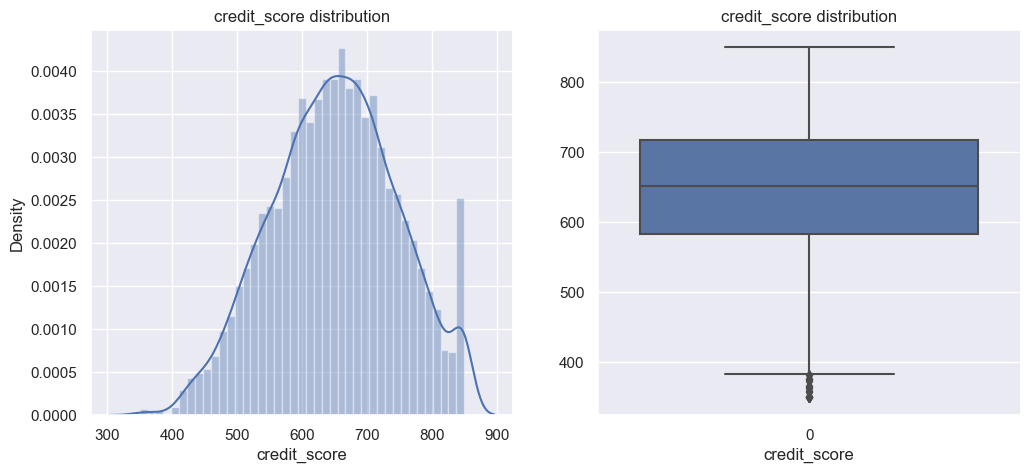

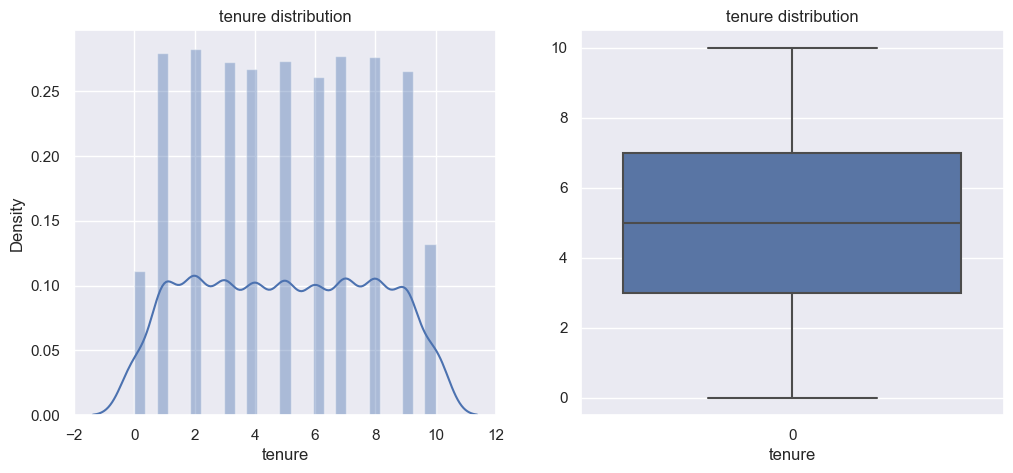

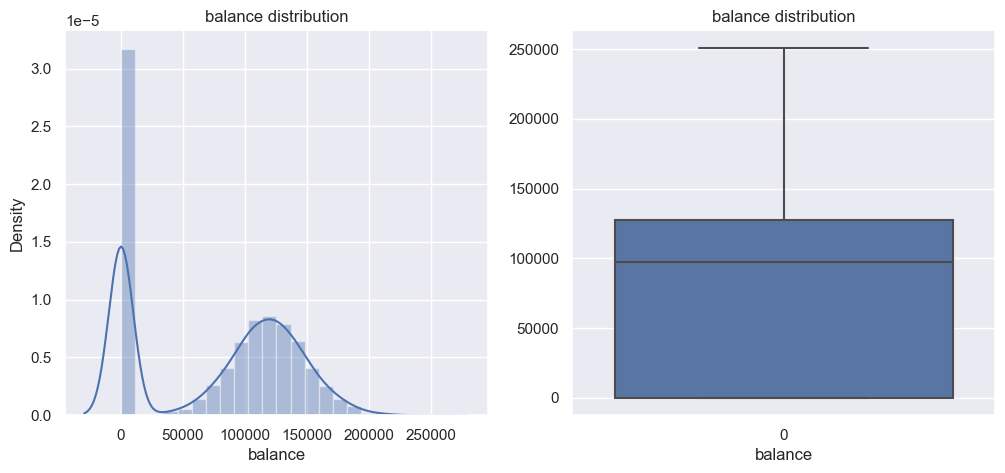

In [218]:
for i in acc_info_num:
  sns.set_theme()
  fig, ax = plt.subplots(1, 2, figsize=(12, 5))
  sns.distplot(df_Pandas[i], ax=ax[0])
  sns.boxplot(df_Pandas[i], ax=ax[1])
  #set xlabel and ylabel for boxplot
  ax[1].set_xlabel(i)
  ax[1].set_ylabel('')
  ax[1].set_title(f'{i} distribution')
  ax[0].set_title(f'{i} distribution')

### Correlation between numerical features

Text(0.5, 1.0, 'Correlation between numerical columns')

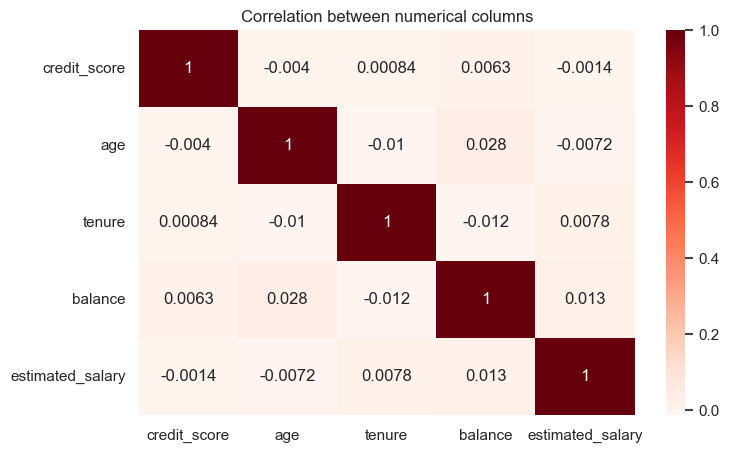

In [219]:
corr=df_Pandas[num_cols].corr()

# Draw the heatmap
plt.figure(figsize=(8,5))
sns.heatmap(corr, annot=True, cmap='Reds')
plt.title('Correlation between numerical columns')

## Bivariate Analysis 

### Demographic Features vs Churn

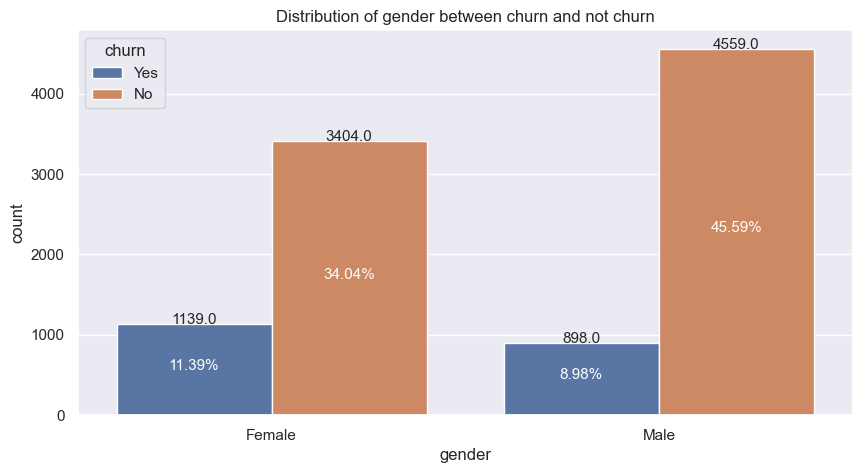

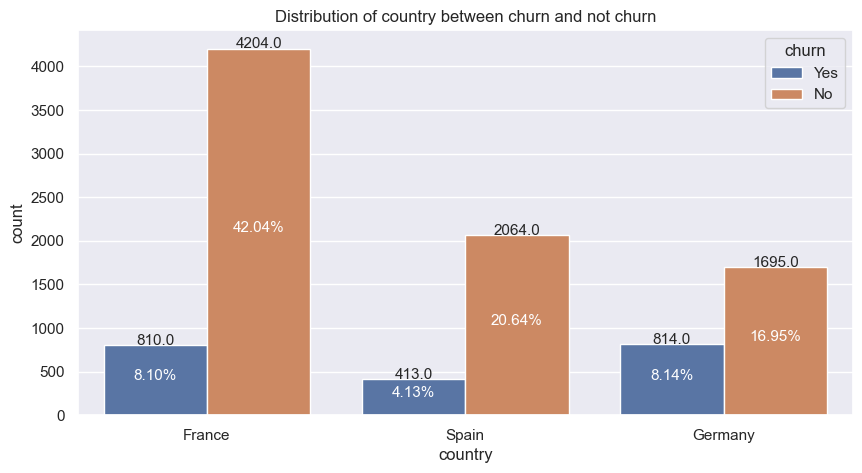

In [220]:
for i in cus_info_cat:
    plt.figure(figsize=(10,5))
    ax = sns.countplot(x=i, hue='churn', data=df_Pandas)
    plt.title(f'Distribution of {i} between churn and not churn')
    # Add count and percentage above each bar
    total = float(len(df_Pandas))
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2., height+3, '{}'.format(height),
                ha="center", fontsize=11) 
        ax.text(p.get_x()+p.get_width()/2., height/2, '{:.2f}%'.format((height/total)*100),
                ha="center", fontsize=11, color='white')
    plt.show()

In [221]:
df_churn=df_Pandas[df_Pandas['churn']=='Yes']
df_no_churn=df_Pandas[df_Pandas['churn']=='No']

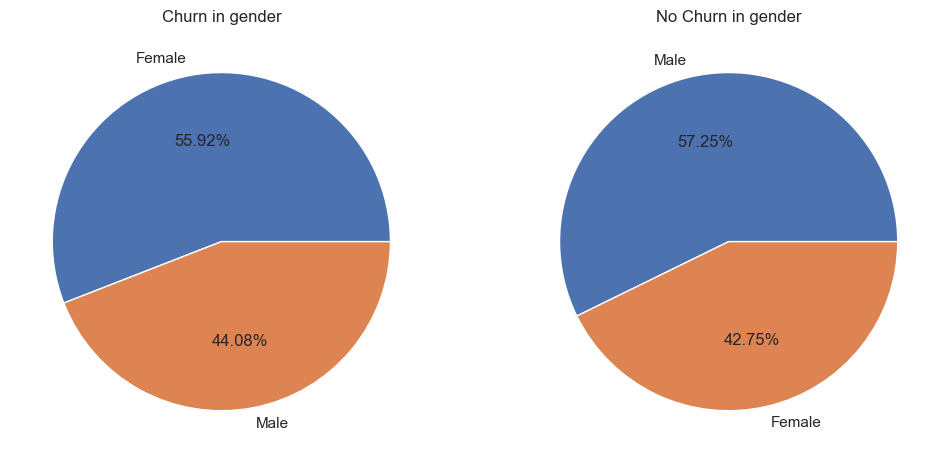

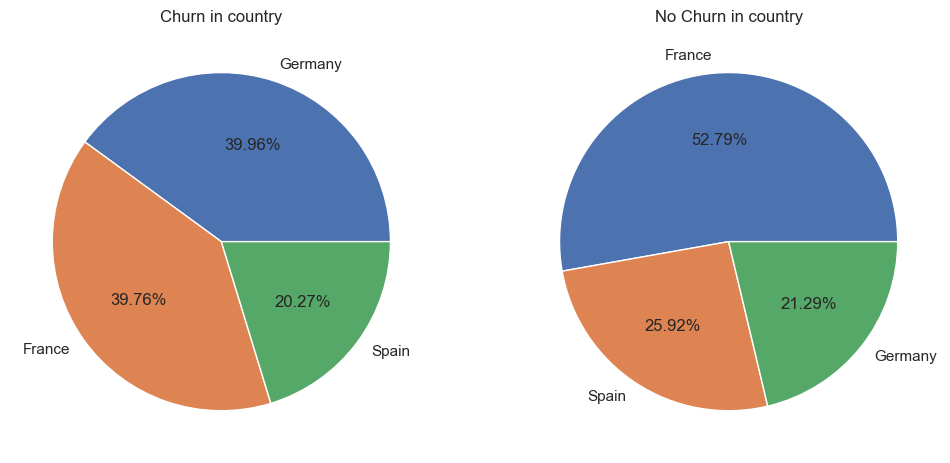

In [222]:
for i in cus_info_cat:
    fig,ax=plt.subplots(1,2,figsize=(12,8))
    ax[0].pie(df_churn[i].value_counts(),labels=df_churn[i].value_counts().index,autopct='%1.2f%%')
    ax[0].set_title(f'Churn in {i}')
    ax[1].pie(df_no_churn[i].value_counts(),labels=df_no_churn[i].value_counts().index,autopct='%1.2f%%')
    ax[1].set_title(f'No Churn in {i}')
    plt.show()

C:\Users\DELL\AppData\Local\Temp\ipykernel_16836\716972808.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_Pandas[i][df_Pandas['churn']=='Yes'], shade=True, color='r', label='Churn')
C:\Users\DELL\AppData\Local\Temp\ipykernel_16836\716972808.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_Pandas[i][df_Pandas['churn']=='No'], shade=True, color='b', label='Not Churn')
C:\Users\DELL\AppData\Local\Temp\ipykernel_16836\716972808.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_Pandas[i][df_Pandas['churn']=='Yes'], shade=True, color='r', label='Churn')
C:\Users\DELL\AppData\Local\Temp\ipykernel_16836\716972

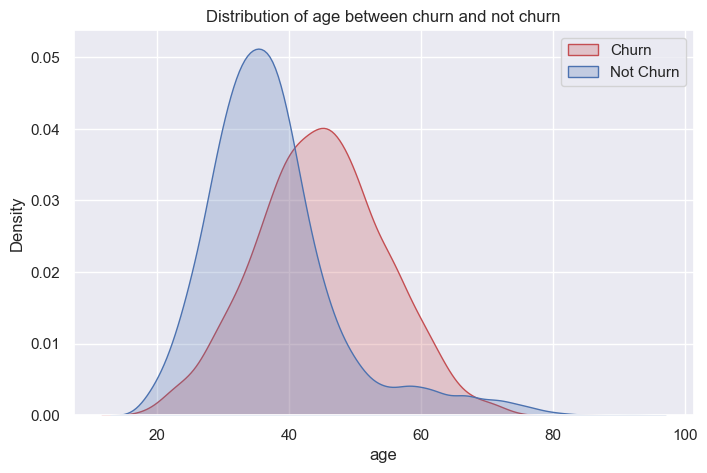

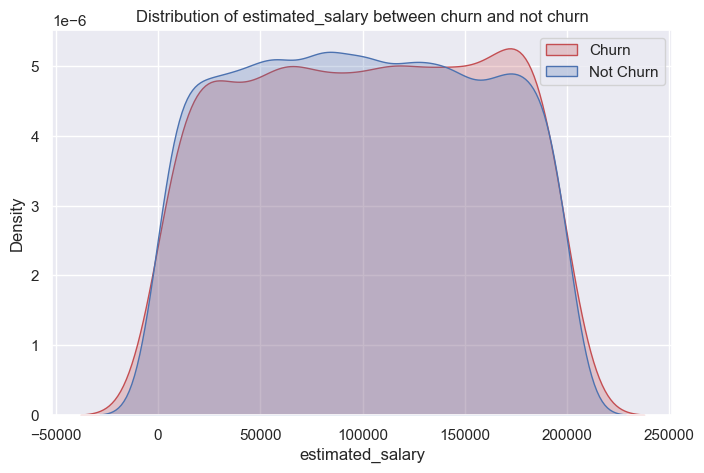

In [223]:
for i in cus_info_num:
    plt.figure(figsize=(8,5))
    sns.kdeplot(df_Pandas[i][df_Pandas['churn']=='Yes'], shade=True, color='r', label='Churn')
    sns.kdeplot(df_Pandas[i][df_Pandas['churn']=='No'], shade=True, color='b', label='Not Churn')
    plt.title(f'Distribution of {i} between churn and not churn')
    plt.legend()

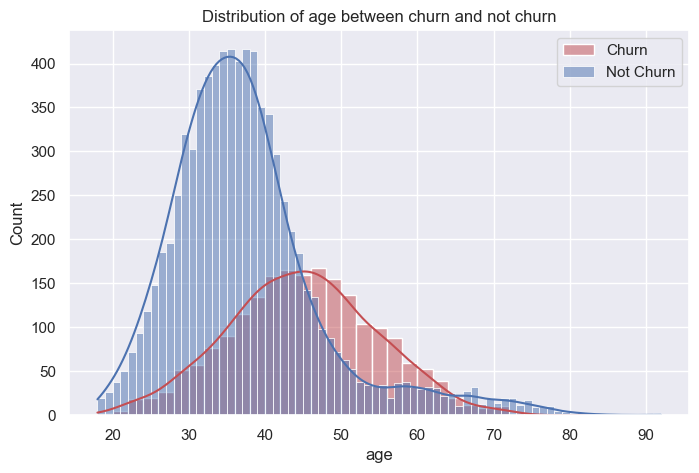

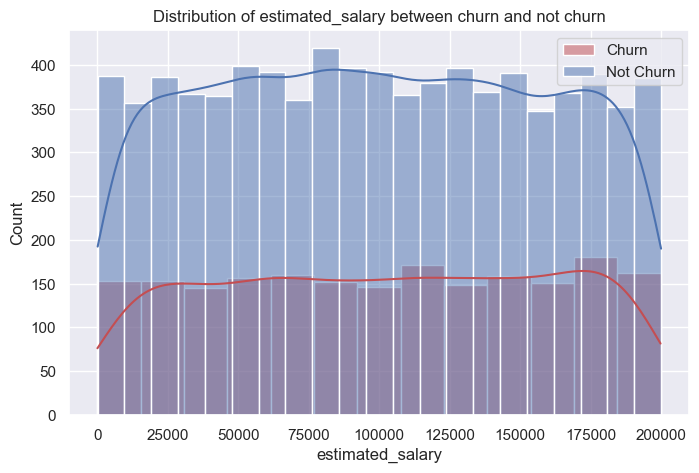

In [224]:
for i in cus_info_num:
    plt.figure(figsize=(8,5))
    sns.histplot(df_Pandas[i][df_Pandas['churn']=='Yes'], color='r', label='Churn', kde=True)
    sns.histplot(df_Pandas[i][df_Pandas['churn']=='No'], color='b', label='Not Churn', kde=True)
    plt.title(f'Distribution of {i} between churn and not churn')
    plt.legend()

### Account Information Features vs Churn

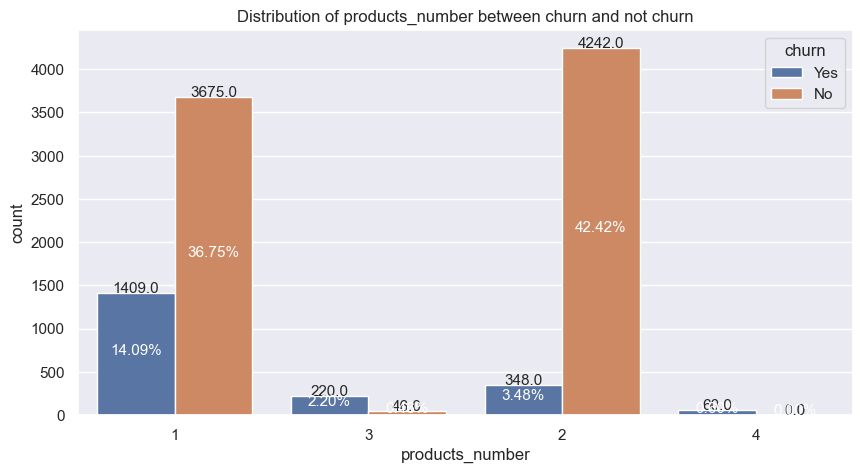

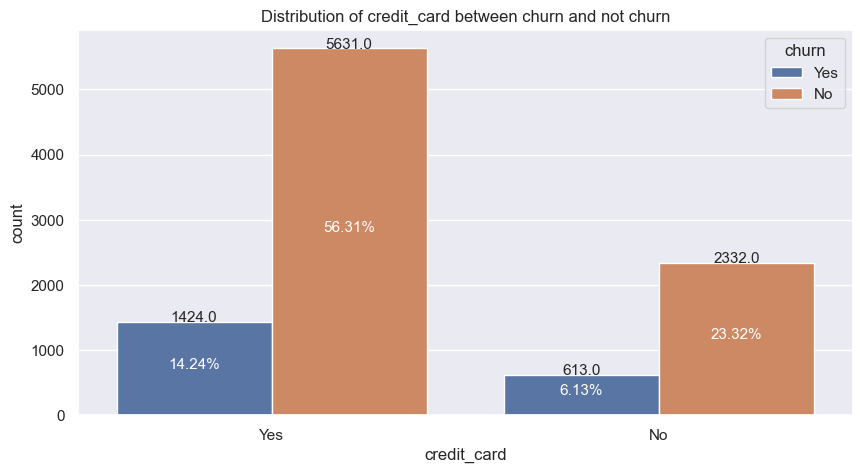

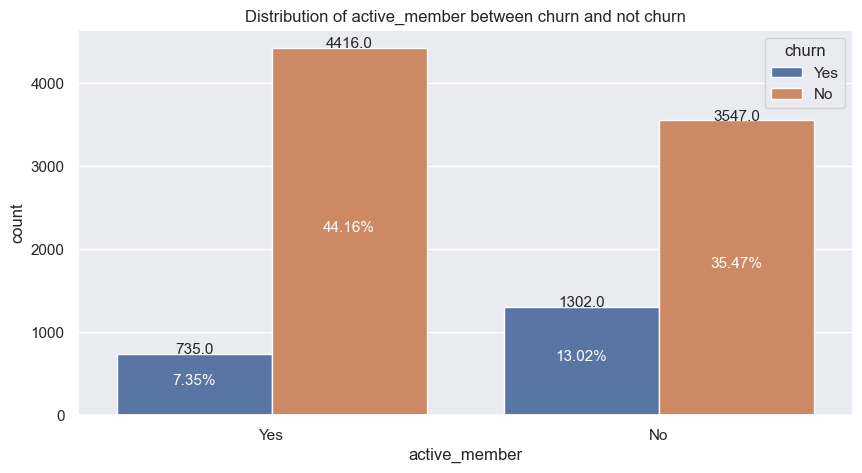

In [225]:
for i in acc_info_cat:
    plt.figure(figsize=(10,5))
    ax = sns.countplot(x=i, hue='churn', data=df_Pandas)
    plt.title(f'Distribution of {i} between churn and not churn')
    # Add count and percentage above each bar
    total = float(len(df_Pandas))
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2., height+3, '{}'.format(height),
                ha="center", fontsize=11) 
        ax.text(p.get_x()+p.get_width()/2., height/2, '{:.2f}%'.format((height/total)*100),
                ha="center", fontsize=11, color='white')
    plt.show()

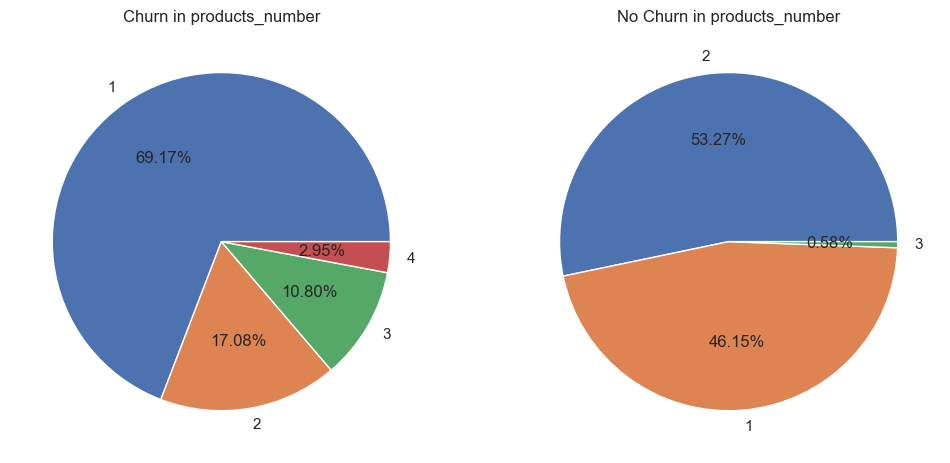

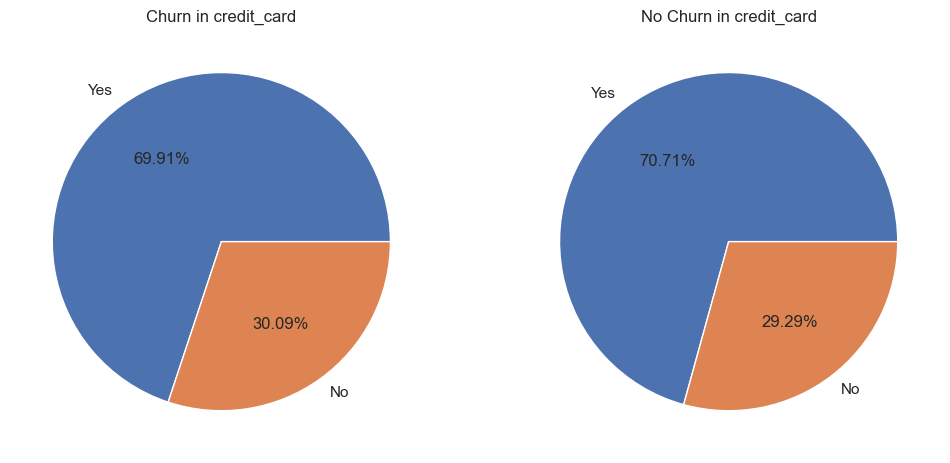

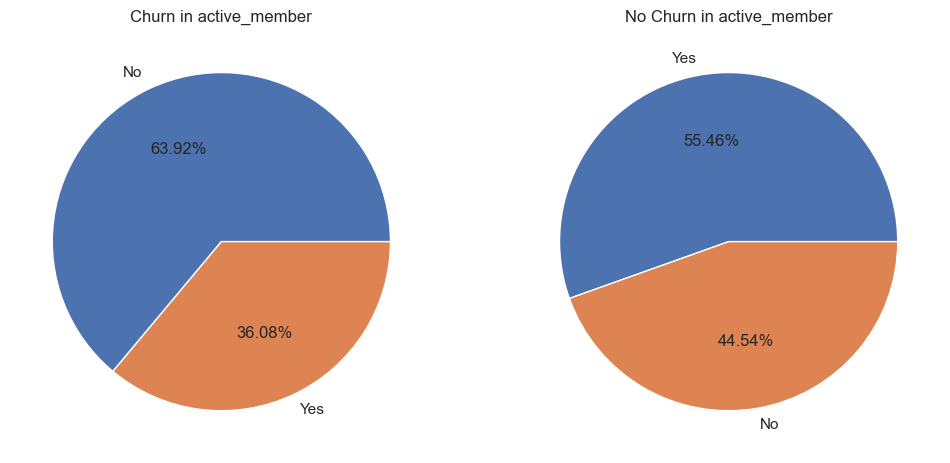

In [226]:
for i in acc_info_cat:
    fig,ax=plt.subplots(1,2,figsize=(12,8))
    ax[0].pie(df_churn[i].value_counts(),labels=df_churn[i].value_counts().index,autopct='%1.2f%%')
    ax[0].set_title(f'Churn in {i}')
    ax[1].pie(df_no_churn[i].value_counts(),labels=df_no_churn[i].value_counts().index,autopct='%1.2f%%')
    ax[1].set_title(f'No Churn in {i}')
    plt.show()

C:\Users\DELL\AppData\Local\Temp\ipykernel_16836\802606758.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_Pandas[i][df_Pandas['churn']=='Yes'], shade=True, color='r', label='Churn')
C:\Users\DELL\AppData\Local\Temp\ipykernel_16836\802606758.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_Pandas[i][df_Pandas['churn']=='No'], shade=True, color='b', label='Not Churn')
C:\Users\DELL\AppData\Local\Temp\ipykernel_16836\802606758.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_Pandas[i][df_Pandas['churn']=='Yes'], shade=True, color='r', label='Churn')
C:\Users\DELL\AppData\Local\Temp\ipykernel_16836\802606

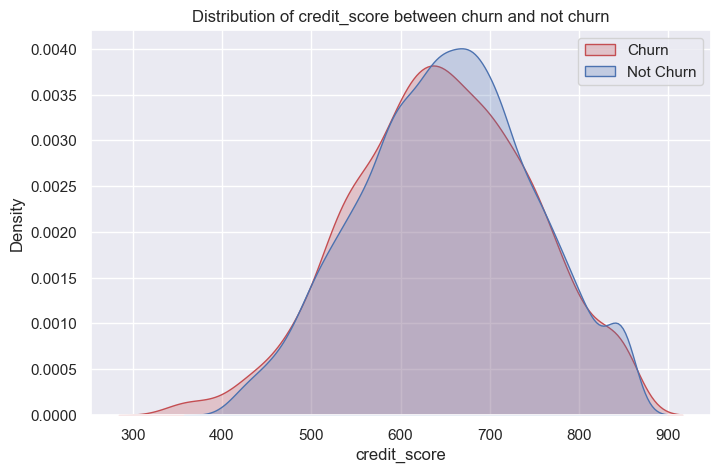

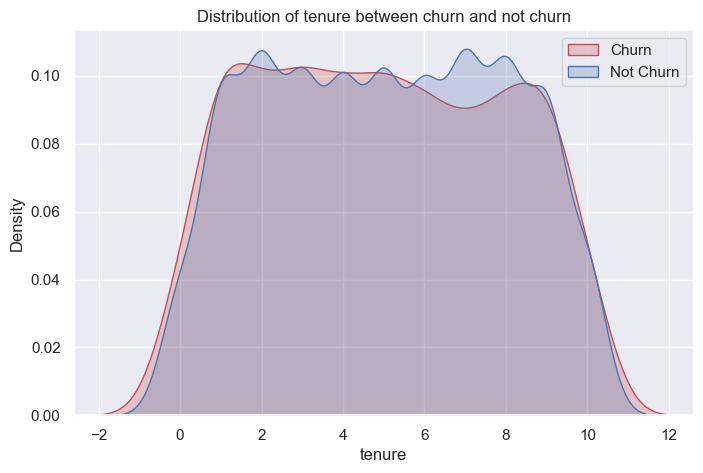

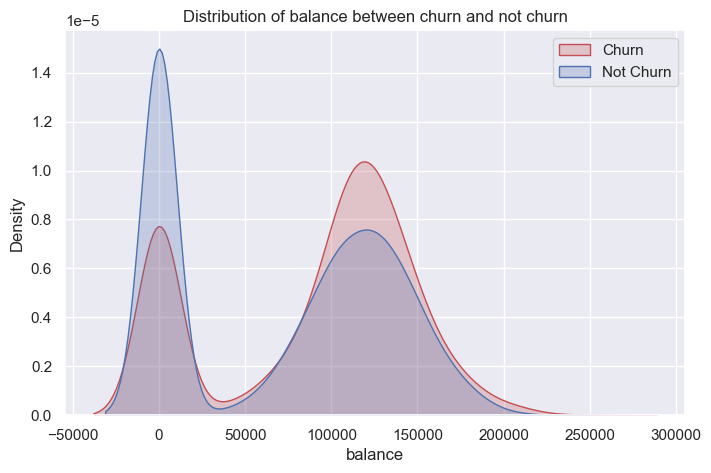

In [227]:
for i in acc_info_num:
    plt.figure(figsize=(8,5))
    sns.kdeplot(df_Pandas[i][df_Pandas['churn']=='Yes'], shade=True, color='r', label='Churn')
    sns.kdeplot(df_Pandas[i][df_Pandas['churn']=='No'], shade=True, color='b', label='Not Churn')
    plt.title(f'Distribution of {i} between churn and not churn')
    plt.legend()

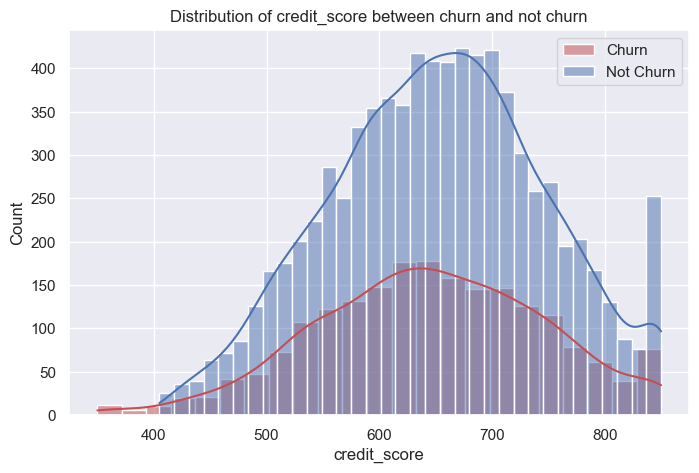

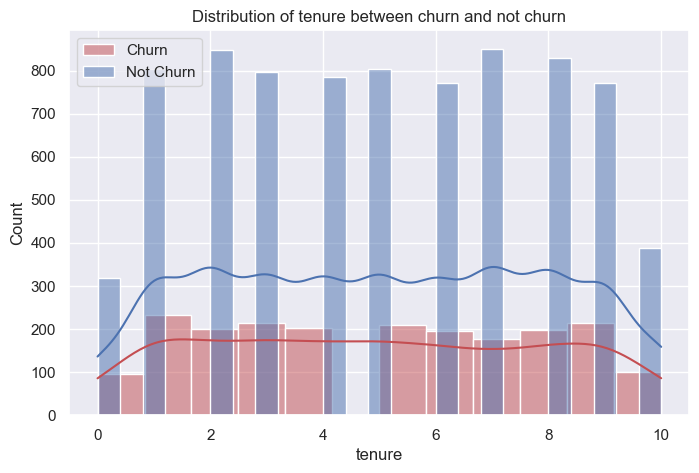

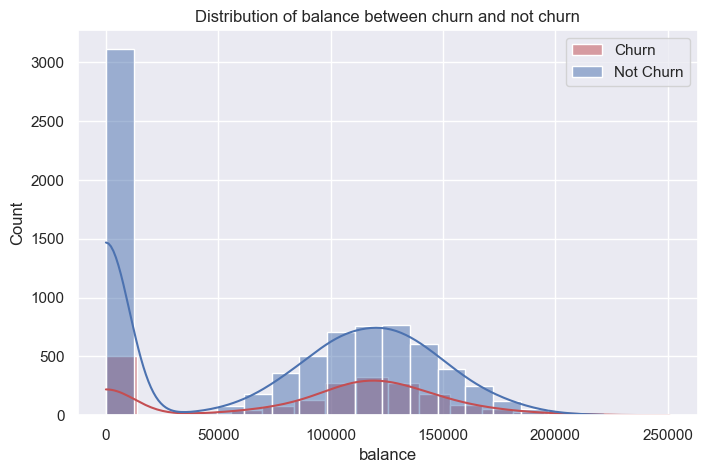

In [228]:
for i in acc_info_num:
    plt.figure(figsize=(8,5))
    sns.histplot(df_Pandas[i][df_Pandas['churn']=='Yes'], color='r', label='Churn', kde=True)
    sns.histplot(df_Pandas[i][df_Pandas['churn']=='No'], color='b', label='Not Churn', kde=True)
    plt.title(f'Distribution of {i} between churn and not churn')
    plt.legend()

<Figure size 1000x800 with 0 Axes>

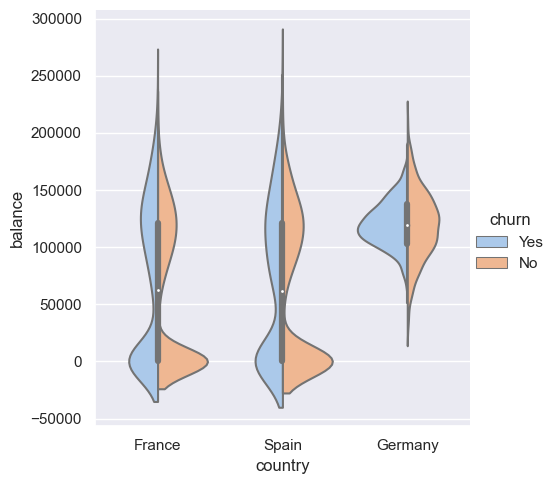

In [229]:
plt.figure(figsize=(10,8))
sns.catplot(data=df_Pandas, x="country", y="balance", hue="churn", kind="violin",
                split=True, palette="pastel",)
plt.show()

# Reprocessing

## Solving abnormality in the data

In [230]:
#age and credit_score have outliers
#handle outliers by using IQR
from pyspark.sql.functions import col, expr

def handle_outliers_by_iqr(data, column_names, multiplier=1.5):
    # Iterate over the column names
    for column_name in column_names:
        # Calculate the quartiles
        q1 = data.approxQuantile(column_name, [0.25], 0.001)[0]
        q3 = data.approxQuantile(column_name, [0.75], 0.001)[0]

        # Calculate the IQR
        iqr = q3 - q1

        # Define the lower and upper bounds
        lower_bound = q1 - (multiplier * iqr)
        upper_bound = q3 + (multiplier * iqr)

        # Replace outliers with the values at the bounds
        data = data.withColumn(column_name,
                               expr(f"IF({column_name} < {lower_bound}, {lower_bound}, "
                                    f"IF({column_name} > {upper_bound}, {upper_bound}, {column_name}))"))

    return data

In [231]:
df_outlier=df

# Define the list of column names containing outliers
outlier_cols = ["age", "credit_score"]

# Use the function to handle outliers for multiple columns
df_outlier = handle_outliers_by_iqr(df_outlier, outlier_cols, multiplier=1.5)

C:\Users\DELL\AppData\Local\Temp\ipykernel_16836\245766870.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_outlier_Pandas[i], ax=ax[0])
C:\Users\DELL\AppData\Local\Temp\ipykernel_16836\245766870.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_outlier_Pandas[i], ax=ax[0])


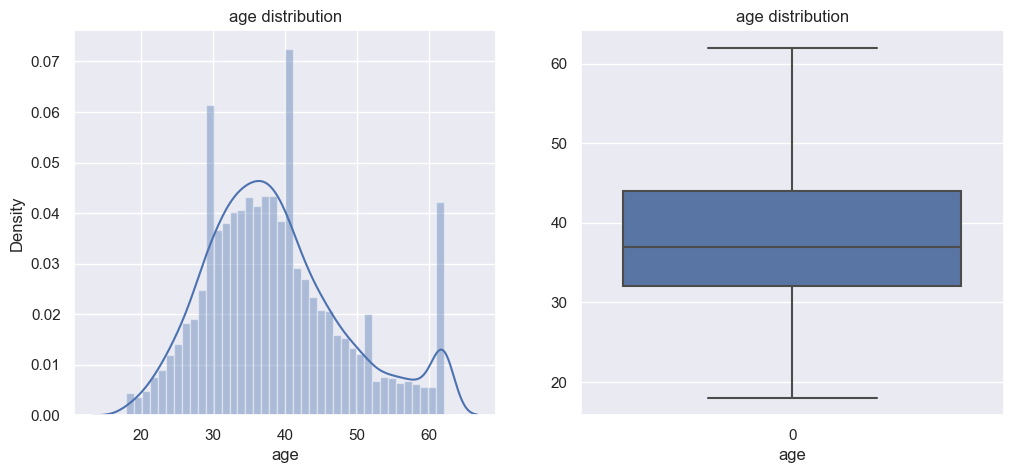

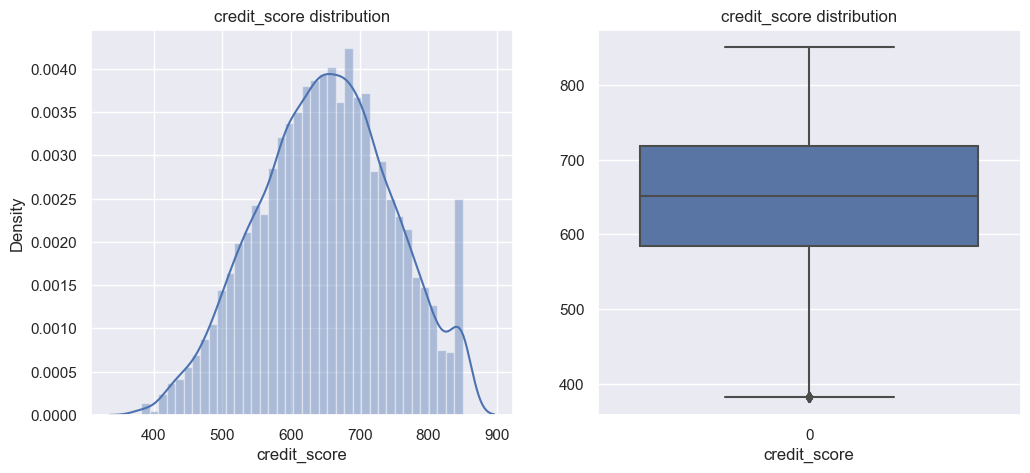

In [232]:
df_outlier_Pandas=df_outlier.toPandas()

for i in outlier_cols:
  sns.set_theme()
  fig, ax = plt.subplots(1, 2, figsize=(12, 5))
  sns.distplot(df_outlier_Pandas[i], ax=ax[0])
  sns.boxplot(df_outlier_Pandas[i], ax=ax[1])
  #set xlabel and ylabel for boxplot
  ax[1].set_xlabel(i)
  ax[1].set_ylabel('')
  ax[1].set_title(f'{i} distribution')
  ax[0].set_title(f'{i} distribution')

## Encoding

In [233]:
df_encoded=df_outlier

In [234]:
df_encoded.show()
df_encoded.printSchema()

+------------+-------+------+----+------+---------+---------------+-----------+-------------+----------------+-----+
|credit_score|country|gender| age|tenure|  balance|products_number|credit_card|active_member|estimated_salary|churn|
+------------+-------+------+----+------+---------+---------------+-----------+-------------+----------------+-----+
|       619.0| France|Female|42.0|     2|      0.0|              1|        Yes|          Yes|       101348.88|  Yes|
|       608.0|  Spain|Female|41.0|     1| 83807.86|              1|         No|          Yes|       112542.58|   No|
|       502.0| France|Female|42.0|     8| 159660.8|              3|        Yes|           No|       113931.57|  Yes|
|       699.0| France|Female|39.0|     1|      0.0|              2|         No|           No|        93826.63|   No|
|       850.0|  Spain|Female|43.0|     2|125510.82|              1|        Yes|          Yes|         79084.1|   No|
|       645.0|  Spain|  Male|44.0|     8|113755.78|             

In [235]:
yes_no_cols=['credit_card', 'active_member', 'churn']
for i in yes_no_cols:
    df_encoded = df_encoded.withColumn(i, when(col(i) == 'Yes', 1).otherwise(0))
df_encoded.show()
df_encoded.printSchema()

+------------+-------+------+----+------+---------+---------------+-----------+-------------+----------------+-----+
|credit_score|country|gender| age|tenure|  balance|products_number|credit_card|active_member|estimated_salary|churn|
+------------+-------+------+----+------+---------+---------------+-----------+-------------+----------------+-----+
|       619.0| France|Female|42.0|     2|      0.0|              1|          1|            1|       101348.88|    1|
|       608.0|  Spain|Female|41.0|     1| 83807.86|              1|          0|            1|       112542.58|    0|
|       502.0| France|Female|42.0|     8| 159660.8|              3|          1|            0|       113931.57|    1|
|       699.0| France|Female|39.0|     1|      0.0|              2|          0|            0|        93826.63|    0|
|       850.0|  Spain|Female|43.0|     2|125510.82|              1|          1|            1|         79084.1|    0|
|       645.0|  Spain|  Male|44.0|     8|113755.78|             

In [236]:
#Convert 'churn' column to String using cast() function with StringType()
from pyspark.sql.types import StringType
df_encoded = df_encoded.withColumn('churn',df_encoded['churn'].cast(StringType()))
df_encoded.show(5)
df_encoded.dtypes

+------------+-------+------+----+------+---------+---------------+-----------+-------------+----------------+-----+
|credit_score|country|gender| age|tenure|  balance|products_number|credit_card|active_member|estimated_salary|churn|
+------------+-------+------+----+------+---------+---------------+-----------+-------------+----------------+-----+
|       619.0| France|Female|42.0|     2|      0.0|              1|          1|            1|       101348.88|    1|
|       608.0|  Spain|Female|41.0|     1| 83807.86|              1|          0|            1|       112542.58|    0|
|       502.0| France|Female|42.0|     8| 159660.8|              3|          1|            0|       113931.57|    1|
|       699.0| France|Female|39.0|     1|      0.0|              2|          0|            0|        93826.63|    0|
|       850.0|  Spain|Female|43.0|     2|125510.82|              1|          1|            1|         79084.1|    0|
+------------+-------+------+----+------+---------+-------------

[('credit_score', 'decimal(11,1)'),
 ('country', 'string'),
 ('gender', 'string'),
 ('age', 'decimal(11,1)'),
 ('tenure', 'int'),
 ('balance', 'double'),
 ('products_number', 'string'),
 ('credit_card', 'int'),
 ('active_member', 'int'),
 ('estimated_salary', 'double'),
 ('churn', 'string')]

In [237]:
#Import Pipeline package
from pyspark.ml import Pipeline

#Create an empty list for Pipeline and Assembler
stages = []

In [238]:
#Import StringIndexer package
from pyspark.ml.feature import StringIndexer

indexed_vars=['country', 'gender', 'products_number']

indexed=[StringIndexer(inputCol=indexed_features ,outputCol=indexed_features+ "_indexed") for indexed_features in indexed_vars]

pipeline = Pipeline(stages=indexed)
indexedModel =  pipeline.fit(df_encoded)
indexedData = indexedModel.transform(df_encoded)

indexedData.show()

+------------+-------+------+----+------+---------+---------------+-----------+-------------+----------------+-----+---------------+--------------+-----------------------+
|credit_score|country|gender| age|tenure|  balance|products_number|credit_card|active_member|estimated_salary|churn|country_indexed|gender_indexed|products_number_indexed|
+------------+-------+------+----+------+---------+---------------+-----------+-------------+----------------+-----+---------------+--------------+-----------------------+
|       619.0| France|Female|42.0|     2|      0.0|              1|          1|            1|       101348.88|    1|            0.0|           1.0|                    0.0|
|       608.0|  Spain|Female|41.0|     1| 83807.86|              1|          0|            1|       112542.58|    0|            2.0|           1.0|                    0.0|
|       502.0| France|Female|42.0|     8| 159660.8|              3|          1|            0|       113931.57|    1|            0.0|        

In [239]:
#Create object of StringIndex class and specify input and output column for label from 'Churn' column
SI_churn=StringIndexer(inputCol='churn', outputCol='label')

indexedData=SI_churn.fit(indexedData).transform(indexedData)

indexedData.show(5)

+------------+-------+------+----+------+---------+---------------+-----------+-------------+----------------+-----+---------------+--------------+-----------------------+-----+
|credit_score|country|gender| age|tenure|  balance|products_number|credit_card|active_member|estimated_salary|churn|country_indexed|gender_indexed|products_number_indexed|label|
+------------+-------+------+----+------+---------+---------------+-----------+-------------+----------------+-----+---------------+--------------+-----------------------+-----+
|       619.0| France|Female|42.0|     2|      0.0|              1|          1|            1|       101348.88|    1|            0.0|           1.0|                    0.0|  1.0|
|       608.0|  Spain|Female|41.0|     1| 83807.86|              1|          0|            1|       112542.58|    0|            2.0|           1.0|                    0.0|  0.0|
|       502.0| France|Female|42.0|     8| 159660.8|              3|          1|            0|       113931.57|

In [240]:
#Import OneHotEncoder package
from pyspark.ml.feature import OneHotEncoder

#Create OHE object and specify input and output column
encoded_vars=['country_indexed', 'gender_indexed', 'products_number_indexed']

encoded=[OneHotEncoder(inputCol=encoded_features ,outputCol=encoded_features+ "_encoded") for encoded_features in encoded_vars]

pipeline = Pipeline(stages=encoded)
encodedModel =  pipeline.fit(indexedData)
encodedData = encodedModel.transform(indexedData)

encodedData.show()

+------------+-------+------+----+------+---------+---------------+-----------+-------------+----------------+-----+---------------+--------------+-----------------------+-----+-----------------------+----------------------+-------------------------------+
|credit_score|country|gender| age|tenure|  balance|products_number|credit_card|active_member|estimated_salary|churn|country_indexed|gender_indexed|products_number_indexed|label|country_indexed_encoded|gender_indexed_encoded|products_number_indexed_encoded|
+------------+-------+------+----+------+---------+---------------+-----------+-------------+----------------+-----+---------------+--------------+-----------------------+-----+-----------------------+----------------------+-------------------------------+
|       619.0| France|Female|42.0|     2|      0.0|              1|          1|            1|       101348.88|    1|            0.0|           1.0|                    0.0|  1.0|          (2,[0],[1.0])|             (1,[],[])|     

In [241]:
#Rename the encoded columns
encodedData=encodedData.withColumnRenamed('country_indexed_encoded', 'country_encoded') \
                        .withColumnRenamed('gender_indexed_encoded', 'gender_encoded') \
                        .withColumnRenamed('products_number_indexed_encoded', 'products_number_encoded')

In [242]:
from pyspark.ml.feature import VectorAssembler

#Specify the input and output columns of the vector assembler
assembler=VectorAssembler(inputCols=['credit_score', 'age', 'tenure', 'balance', 'credit_card', 'active_member', 'estimated_salary', 'country_encoded', 'gender_encoded', 'products_number_encoded'],
                          outputCol='features')
df_assembler=assembler.transform(encodedData)
df_assembler.show(5)

+------------+-------+------+----+------+---------+---------------+-----------+-------------+----------------+-----+---------------+--------------+-----------------------+-----+---------------+--------------+-----------------------+--------------------+
|credit_score|country|gender| age|tenure|  balance|products_number|credit_card|active_member|estimated_salary|churn|country_indexed|gender_indexed|products_number_indexed|label|country_encoded|gender_encoded|products_number_encoded|            features|
+------------+-------+------+----+------+---------+---------------+-----------+-------------+----------------+-----+---------------+--------------+-----------------------+-----+---------------+--------------+-----------------------+--------------------+
|       619.0| France|Female|42.0|     2|      0.0|              1|          1|            1|       101348.88|    1|            0.0|           1.0|                    0.0|  1.0|  (2,[0],[1.0])|     (1,[],[])|          (3,[0],[1.0])|[619.0

## Scaling

In [243]:
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml import Pipeline

# Create the MinMaxScaler
scaler = MinMaxScaler(inputCol='features', outputCol='scaled_features')

# Create the pipeline with the scaler stage
pipeline = Pipeline(stages=[scaler])

# Fit the pipeline on the data
pipelineModel = pipeline.fit(df_assembler)

# Apply the transformation to the data
scaledData = pipelineModel.transform(df_assembler)

# Show the scaled data
scaledData.show(5)

+------------+-------+------+----+------+---------+---------------+-----------+-------------+----------------+-----+---------------+--------------+-----------------------+-----+---------------+--------------+-----------------------+--------------------+--------------------+
|credit_score|country|gender| age|tenure|  balance|products_number|credit_card|active_member|estimated_salary|churn|country_indexed|gender_indexed|products_number_indexed|label|country_encoded|gender_encoded|products_number_encoded|            features|     scaled_features|
+------------+-------+------+----+------+---------+---------------+-----------+-------------+----------------+-----+---------------+--------------+-----------------------+-----+---------------+--------------+-----------------------+--------------------+--------------------+
|       619.0| France|Female|42.0|     2|      0.0|              1|          1|            1|       101348.88|    1|            0.0|           1.0|                    0.0|  1.

In [244]:
df_model=scaledData.select('features', 'scaled_features', 'churn', 'label')
df_model.show(5)

+--------------------+--------------------+-----+-----+
|            features|     scaled_features|churn|label|
+--------------------+--------------------+-----+-----+
|[619.0,42.0,2.0,0...|[0.50641025641025...|    1|  1.0|
|(13,[0,1,2,3,5,6,...|(13,[0,1,2,3,5,6,...|    0|  0.0|
|[502.0,42.0,8.0,1...|[0.25641025641025...|    1|  1.0|
|(13,[0,1,2,6,7,11...|(13,[0,1,2,6,7,11...|    0|  0.0|
|[850.0,43.0,2.0,1...|[1.0,0.5681818181...|    0|  0.0|
+--------------------+--------------------+-----+-----+
only showing top 5 rows



# Proposed Model (Supervised Machine Learning)

In [245]:
#Splitting normalized dataframe into 75% and 25%
train, test = df_model.randomSplit([0.75, 0.25], seed = 742)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 7547
Test Dataset Count: 2453


## Logistic Regression

In [246]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Create a LogisticRegression object
lr = LogisticRegression(featuresCol='features', labelCol='label')

# Define the parameter grid and evaluator
paramGrid = (ParamGridBuilder()
                .addGrid(lr.maxIter, [10, 100, 200])
                .build())
evaluator = BinaryClassificationEvaluator(labelCol='label')

# Create a CrossValidator and adjust numFolds
crossval = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

# Fit the CrossValidator to the training data
cvModel = crossval.fit(train)

# Get the best model from cross-validation
bestModel = cvModel.bestModel

# Make predictions on the test data using the best model
predictionLR = bestModel.transform(test)

# Select specific columns for display
predictionLR.select('features', 'churn', 'label', 'rawPrediction', 'prediction', 'probability').show(10)


+--------------------+-----+-----+--------------------+----------+--------------------+
|            features|churn|label|       rawPrediction|prediction|         probability|
+--------------------+-----+-----+--------------------+----------+--------------------+
|(13,[0,1,2,3,4,6]...|    1|  1.0|[-21.155518390641...|       1.0|[6.49045436739787...|
|(13,[0,1,2,3,4,6,...|    1|  1.0|[-20.936654222196...|       1.0|[8.07842321584574...|
|(13,[0,1,2,3,4,6,...|    1|  1.0|[-23.402506376470...|       1.0|[6.86152449331680...|
|(13,[0,1,2,3,4,6,...|    1|  1.0|[-19.463572281215...|       1.0|[3.52434129524864...|
|(13,[0,1,2,3,4,6,...|    1|  1.0|[-1.0220474901397...|       1.0|[0.26462876619882...|
|(13,[0,1,2,3,4,6,...|    0|  0.0|[-0.1187060715645...|       1.0|[0.47035828105019...|
|(13,[0,1,2,3,4,6,...|    0|  0.0|[-0.0092907006627...|       1.0|[0.49767734154138...|
|(13,[0,1,2,3,4,6,...|    0|  0.0|[0.07319418499285...|       0.0|[0.51829038125372...|
|(13,[0,1,2,3,4,6,...|    0|  0.

In [247]:
#Calculate Accuracy using Multiclass Evaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

eval_LR = MulticlassClassificationEvaluator(predictionCol='prediction',labelCol='label', metricName='accuracy')
acc_LR = eval_LR.evaluate(predictionLR)
print("accuracy=%g" %(acc_LR))

accuracy=0.846311


In [248]:
tp_LR=predictionLR[(predictionLR.label==1) & (predictionLR.prediction==1)].count()
tn_LR=predictionLR[(predictionLR.label==0) & (predictionLR.prediction==0)].count()
fp_LR=predictionLR[(predictionLR.label==0) & (predictionLR.prediction==1)].count()
fn_LR=predictionLR[(predictionLR.label==1) & (predictionLR.prediction==0)].count()

print("Confusion Matrix of Logistic Regression Model:")
print("True Positive:", tp_LR)
print("True Negative:", tn_LR)
print("False Positive:", fp_LR)
print("False Negative:", fn_LR)

Confusion Matrix of Logistic Regression Model:
True Positive: 226
True Negative: 1850
False Positive: 89
False Negative: 288


In [249]:
# Calculate accuracy
accuracy_LR = (tp_LR + tn_LR) / (predictionLR.count())

# Calculate precision
precision_LR = tp_LR / (tp_LR + fp_LR)

# Calculate recall
recall_LR = tp_LR / (tp_LR + fn_LR)

# Calculate F1-score
f1_score_LR = 2 * (precision_LR * recall_LR) / (precision_LR + recall_LR)

In [250]:
print('Evaluation of Logistic Regression Model:')
print('Accuracy:', accuracy_LR)
print('Precision:', precision_LR)
print('Recall:', recall_LR)
print('F1-Score:', f1_score_LR)

Evaluation of Logistic Regression Model:
Accuracy: 0.8463106400326131
Precision: 0.7174603174603175
Recall: 0.4396887159533074
F1-Score: 0.5452352231604343


In [251]:
#Use BinaryClassificationEvaluator for Test Area Under ROC Calculation
#Default Metric for Binary Class is Area Under ROC
from pyspark.ml.evaluation import BinaryClassificationEvaluator
AUC_LR = BinaryClassificationEvaluator()
print('Test Area Under ROC in Logistic Regression Model:', AUC_LR.evaluate(predictionLR))

Test Area Under ROC in Logistic Regression Model: 0.8410729587034883


## Decision Tree

In [252]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Create a DecisionTreeClassifier object
dt = DecisionTreeClassifier(featuresCol='features', labelCol='label')

# Define the parameter grid for different combinations of maxDepth and impurity
paramGrid = (ParamGridBuilder()
             .addGrid(dt.maxDepth, [3, 5, 7])
             .addGrid(dt.impurity, ['gini', 'entropy'])
             .build())

# Define the evaluator for model evaluation
evaluator = BinaryClassificationEvaluator(labelCol='label')

# Create a cross-validator
crossval = CrossValidator(estimator=dt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

# Fit the cross-validator to the training data
cvModel = crossval.fit(train)

# Get the best model from cross-validation
bestModel = cvModel.bestModel

# Make predictions on the test data using the best model
predictionDT = bestModel.transform(test)

# Select specific columns for display
predictionDT.select('features', 'churn', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+--------------------+-----+-----+--------------+----------+--------------------+
|            features|churn|label| rawPrediction|prediction|         probability|
+--------------------+-----+-----+--------------+----------+--------------------+
|(13,[0,1,2,3,4,6]...|    1|  1.0| [181.0,479.0]|       1.0|[0.27424242424242...|
|(13,[0,1,2,3,4,6,...|    1|  1.0|   [33.0,95.0]|       1.0|[0.2578125,0.7421...|
|(13,[0,1,2,3,4,6,...|    1|  1.0| [181.0,479.0]|       1.0|[0.27424242424242...|
|(13,[0,1,2,3,4,6,...|    1|  1.0|   [33.0,95.0]|       1.0|[0.2578125,0.7421...|
|(13,[0,1,2,3,4,6,...|    1|  1.0| [181.0,479.0]|       1.0|[0.27424242424242...|
|(13,[0,1,2,3,4,6,...|    0|  0.0| [181.0,479.0]|       1.0|[0.27424242424242...|
|(13,[0,1,2,3,4,6,...|    0|  0.0| [181.0,479.0]|       1.0|[0.27424242424242...|
|(13,[0,1,2,3,4,6,...|    0|  0.0| [181.0,479.0]|       1.0|[0.27424242424242...|
|(13,[0,1,2,3,4,6,...|    0|  0.0| [181.0,479.0]|       1.0|[0.27424242424242...|
|(13,[0,1,2,3,4,

In [253]:
#Calculate Accuracy using Multiclass Evaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

eval_DT = MulticlassClassificationEvaluator(predictionCol='prediction',labelCol='label', metricName='accuracy')
acc_DT = eval_DT.evaluate(predictionDT)
print("accuracy=%g" %(acc_DT))

accuracy=0.844272


In [254]:
tp_DT=predictionDT[(predictionDT.label==1) & (predictionDT.prediction==1)].count()
tn_DT=predictionDT[(predictionDT.label==0) & (predictionDT.prediction==0)].count()
fp_DT=predictionDT[(predictionDT.label==0) & (predictionDT.prediction==1)].count()
fn_DT=predictionDT[(predictionDT.label==1) & (predictionDT.prediction==0)].count()

print("Confusion Matrix of Decision Tree Model:")
print("True Positive:", tp_DT)
print("True Negative:", tn_DT)
print("False Positive:", fp_DT)
print("False Negative:", fn_DT)

Confusion Matrix of Decision Tree Model:
True Positive: 207
True Negative: 1864
False Positive: 75
False Negative: 307


In [255]:
# Calculate accuracy
accuracy_DT = (tp_DT + tn_DT) / (predictionDT.count())

# Calculate precision
precision_DT = tp_DT / (tp_DT + fp_DT)

# Calculate recall
recall_DT = tp_DT / (tp_DT + fn_DT)

# Calculate F1-score
f1_score_DT = 2 * (precision_DT * recall_DT) / (precision_DT + recall_DT)

In [256]:
print('Evaluation of Decision Tree Model:')
print('Accuracy:', accuracy_DT)
print('Precision:', precision_DT)
print('Recall:', recall_DT)
print('F1-Score:', f1_score_DT)

Evaluation of Decision Tree Model:
Accuracy: 0.8442723196086425
Precision: 0.7340425531914894
Recall: 0.4027237354085603
F1-Score: 0.5201005025125628


In [257]:
AUC_DT = BinaryClassificationEvaluator()
print('Test Area Under ROC in Decision Tree Model:', AUC_DT.evaluate(predictionDT))

Test Area Under ROC in Decision Tree Model: 0.7109430028314969


## Random Forest

In [258]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Create a RandomForestClassifier object
rf = RandomForestClassifier(labelCol='label', featuresCol='features')

# Define the parameter grid for different combinations of numTrees and impurity
paramGrid = (ParamGridBuilder()
             .addGrid(rf.numTrees, [10, 15, 20, 25, 30])
             .addGrid(rf.impurity, ['gini', 'entropy'])
             .build())

# Define the evaluator for model evaluation
evaluator = BinaryClassificationEvaluator(labelCol='label')

# Create a cross-validator
crossval = CrossValidator(estimator=rf, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

# Fit the cross-validator to the training data
cvModel = crossval.fit(train)

# Get the best model from cross-validation
bestModel = cvModel.bestModel

# Make predictions on the test data using the best model
predictionRD = bestModel.transform(test)

# Select specific columns for display
predictionRD.select('features', 'churn', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+--------------------+-----+-----+--------------------+----------+--------------------+
|            features|churn|label|       rawPrediction|prediction|         probability|
+--------------------+-----+-----+--------------------+----------+--------------------+
|(13,[0,1,2,3,4,6]...|    1|  1.0|[11.2334132939159...|       1.0|[0.37444710979719...|
|(13,[0,1,2,3,4,6,...|    1|  1.0|[15.7826679985021...|       0.0|[0.52608893328340...|
|(13,[0,1,2,3,4,6,...|    1|  1.0|[10.0996500156861...|       1.0|[0.33665500052287...|
|(13,[0,1,2,3,4,6,...|    1|  1.0|[16.5297645005337...|       0.0|[0.55099215001779...|
|(13,[0,1,2,3,4,6,...|    1|  1.0|[13.1254153580183...|       1.0|[0.43751384526727...|
|(13,[0,1,2,3,4,6,...|    0|  0.0|[13.8073412587648...|       1.0|[0.46024470862549...|
|(13,[0,1,2,3,4,6,...|    0|  0.0|[13.8073412587648...|       1.0|[0.46024470862549...|
|(13,[0,1,2,3,4,6,...|    0|  0.0|[17.7926234935146...|       0.0|[0.59308744978382...|
|(13,[0,1,2,3,4,6,...|    0|  0.

In [259]:
#Calculate Accuracy using Multiclass Evaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

eval_RD = MulticlassClassificationEvaluator(predictionCol='prediction',labelCol='label', metricName='accuracy')
acc_RD = eval_RD.evaluate(predictionRD)
print("accuracy=%g" %(acc_RD))

accuracy=0.852426


In [260]:
tp_RD=predictionRD[(predictionRD.label==1) & (predictionRD.prediction==1)].count()
tn_RD=predictionRD[(predictionRD.label==0) & (predictionRD.prediction==0)].count()
fp_RD=predictionRD[(predictionRD.label==0) & (predictionRD.prediction==1)].count()
fn_RD=predictionRD[(predictionRD.label==1) & (predictionRD.prediction==0)].count()

print("Confusion Matrix of Random Forest Model:")
print("True Positive:", tp_RD)
print("True Negative:", tn_RD)
print("False Positive:", fp_RD)
print("False Negative:", fn_RD)

Confusion Matrix of Random Forest Model:
True Positive: 204
True Negative: 1887
False Positive: 52
False Negative: 310


In [261]:
# Calculate accuracy
accuracy_RD = (tp_RD + tn_RD) / (predictionRD.count())

# Calculate precision
precision_RD = tp_RD / (tp_RD + fp_RD)

# Calculate recall
recall_RD = tp_RD / (tp_RD + fn_RD)

# Calculate F1-score
f1_score_RD = 2 * (precision_RD * recall_RD) / (precision_RD + recall_RD)

In [262]:
print('Evaluation of Random Forest Model:')
print('Accuracy:', accuracy_RD)
print('Precision:', precision_RD)
print('Recall:', recall_RD)
print('F1-Score:', f1_score_RD)

Evaluation of Random Forest Model:
Accuracy: 0.852425601304525
Precision: 0.796875
Recall: 0.3968871595330739
F1-Score: 0.5298701298701299


In [263]:
AUC_RD = BinaryClassificationEvaluator()
print('Test Area Under ROC:', AUC_RD.evaluate(predictionRD))

Test Area Under ROC: 0.8462703908910486


# Summary

In [264]:
print('Logistic Regression Model:')
print('Accuracy:', accuracy_LR)
print('Precision:', precision_LR)
print('Recall:', recall_LR)
print('F1-Score:', f1_score_LR)
print('Test Area Under ROC:', AUC_LR.evaluate(predictionLR))

print('*'*20)

print('Decision Tree Model:')
print('Accuracy:', accuracy_DT)
print('Precision:', precision_DT)
print('Recall:', recall_DT)
print('F1-Score:', f1_score_DT)
print('Test Area Under ROC:', AUC_DT.evaluate(predictionDT))

print('*'*20)

print('Random Forest Model:')
print('Accuracy:', accuracy_RD)
print('Precision:', precision_RD)
print('Recall:', recall_RD)
print('F1-Score:', f1_score_RD)
print('Test Area Under ROC:', AUC_RD.evaluate(predictionRD))


Logistic Regression Model:
Accuracy: 0.8463106400326131
Precision: 0.7174603174603175
Recall: 0.4396887159533074
F1-Score: 0.5452352231604343
Test Area Under ROC: 0.8410729587034883
********************
Decision Tree Model:
Accuracy: 0.8442723196086425
Precision: 0.7340425531914894
Recall: 0.4027237354085603
F1-Score: 0.5201005025125628
Test Area Under ROC: 0.7109430028314969
********************
Random Forest Model:
Accuracy: 0.852425601304525
Precision: 0.796875
Recall: 0.3968871595330739
F1-Score: 0.5298701298701299
Test Area Under ROC: 0.8462703908910486
